In [59]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import cv2

from ultralytics import YOLO
from sklearn import linear_model

In [60]:
pre = "/home/012392471@SJSUAD/master_project/OpenPCDet/data/kitti"

## Loading ImageSet

In [61]:
with open(f"{pre}/ImageSets/custom_val.txt", "r") as fp:
    vals = fp.readlines()

vals = [v.strip() for v in vals]

In [62]:
idx = vals[0]

In [63]:
idx

'000439'

## Velodyne

In [64]:
prefix_velo = f"{pre}/training/velodyne"

## Image

In [65]:
prefix_im = f"{pre}/training/image_2"

In [66]:
img_path = os.path.join(prefix_im, f"{idx}.png")

In [67]:
img = Image.open(img_path)

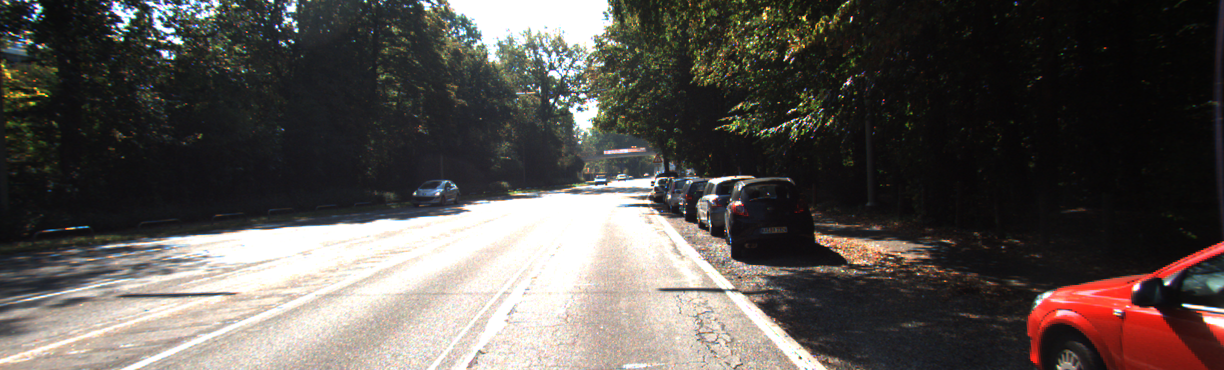

In [68]:
img

In [69]:
img = np.array(img)

## Calib

In [70]:
prefix_calib = f"{pre}/training/calib"

In [71]:
calib_path = os.path.join(prefix_calib, f"{idx}.txt")

In [72]:
calib = {}
with open(calib_path, "r") as fp:
    for line in fp.readlines():
        if line.strip() == '' or line[0] == '#':
            continue
        key, value = line.split(':', 1)
        calib[key] = np.array([float(x) for x in value.split()])

In [73]:
calib['P0'] = calib['P0'].reshape((3,4))
calib['P1'] = calib['P1'].reshape((3,4))
calib['P2'] = calib['P2'].reshape((3,4))
calib['P3'] = calib['P3'].reshape((3,4))

In [74]:
calib['R0_rect'] = calib['R0_rect'].reshape((3,3))
calib['Tr_velo_to_cam'] = calib['Tr_velo_to_cam'].reshape((3,4))
calib['Tr_imu_to_velo'] = calib['Tr_imu_to_velo'].reshape((3,4))

In [75]:
calib

{'P0': array([[     707.05,           0,      604.08,           0],
        [          0,      707.05,      180.51,           0],
        [          0,           0,           1,           0]]),
 'P1': array([[     707.05,           0,      604.08,     -379.78],
        [          0,      707.05,      180.51,           0],
        [          0,           0,           1,           0]]),
 'P2': array([[     707.05,           0,      604.08,      45.758],
        [          0,      707.05,      180.51,    -0.34542],
        [          0,           0,           1,    0.004981]]),
 'P3': array([[     707.05,           0,      604.08,     -334.11],
        [          0,      707.05,      180.51,      2.3307],
        [          0,           0,           1,   0.0032012]]),
 'R0_rect': array([[    0.99991,    0.010093,  -0.0085119],
        [  -0.010127,     0.99994,  -0.0040377],
        [  0.0084707,   0.0041235,     0.99996]]),
 'Tr_velo_to_cam': array([[   0.006928,    -0.99997,  -0.0027578

## Sensor Fusion

In [76]:
def project_velo_to_cam2(points, calib):
    # Reshape points
    velo = np.hstack((points, np.ones((points.shape[0], 1))))
    
    # Convert velodyne coordinates to camera coordinates
    velo_to_cam = np.vstack((calib['Tr_velo_to_cam'], np.array([0, 0, 0, 1])))
    cam = velo.dot(velo_to_cam.T)
    
    # Only keep points in front of the camera (positive z)
    cam = cam[cam[:, 2] > 0]
    
    # Project to image plane
    cam2 = cam.dot(calib['P2'].T)
    
    # Normalize homogeneous coordinates
    cam2_points = cam2[:, :2] / cam2[:, 2:3]
    
    return cam2_points, cam[:, 2]  # Return points and depths

In [77]:
def filter_points(points_2d, depths, image):
    mask = (points_2d[:, 0] >= 0) & (points_2d[:, 0] < image.shape[1]) & \
           (points_2d[:, 1] >= 0) & (points_2d[:, 1] < image.shape[0])
    return points_2d[mask], depths[mask]

In [78]:
# Source: https://github.com/itberrios/CV_tracking/blob/main/kitti_tracker/kitti_utils.py

def remove_ground_plane(xyz, threshold=0.1, trials=4000):
    ransac = linear_model.RANSACRegressor(
                              linear_model.LinearRegression(),
                              residual_threshold=threshold,
                              max_trials=trials
                              )

    X = xyz[:, :2]
    y = xyz[:, -1]
    
    ransac.fit(X, y)

    # remove outlier points (i.e. remove ground plane)
    mask = ransac.inlier_mask_
    xyz = xyz[~mask]
    
    return xyz

In [79]:
def visualize_projection(image, points_2d, depths):
    plt.figure(figsize=(15, 5))
    
    # Color points by depth
    colors = depths / np.max(depths)
    plt.scatter(points_2d[:, 0], points_2d[:, 1], c=colors, 
               cmap='viridis', s=1, alpha=0.5)
    
    # Show image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## 2D Object Detection

In [80]:
yolo = YOLO('/home/012392471@SJSUAD/master_project/weights/yolo11m.pt')

In [81]:
result = yolo.predict(img, iou=0.5, conf=0.5)


0: 224x640 5 cars, 7.5ms
Speed: 0.7ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)


In [82]:
def draw_bboxes(np_im):
    for box in result[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])
        class_id = int(box.cls)
        class_name = result[0].names[class_id]
        confidence = box.conf.item()
            
        # Draw rectangle and label on the frame
        cv2.rectangle(np_im, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{class_name}: {confidence:.2f}"
        cv2.putText(np_im, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(np_im)

In [83]:
def filter_by_bboxes(points_2d, bboxes, point_depths):
    pts = np.array([])
    depths = np.array([])
    for box in bboxes:
        bbox = box.xyxy.tolist()[0]
    
        mask = (points_2d[:, 0] >= bbox[0]) & (points_2d[:, 0] <= bbox[2]) & \
               (points_2d[:, 1] >= bbox[1]) & (points_2d[:, 1] <= bbox[3])

        if(len(pts) == 0):
            pts = np.array(points_2d[mask])
        else:
            pts = np.concatenate((pts, points_2d[mask]), axis=0)

        
        depths = np.concatenate((depths, point_depths[mask]), axis=0)

    return pts, depths

## 2D Segmentation

In [ ]:
# TODO

## Testing

In [84]:
bin_path = os.path.join(prefix_velo, f"{idx}.bin")

In [85]:
points = np.fromfile(bin_path, '<f4')
points = points.reshape((-1, 4))
points = points[:, :3]

In [86]:
points.shape

(111659, 3)

In [87]:
points = remove_ground_plane(points) 

In [88]:
points_2d, depths = project_velo_to_cam2(points, calib)

In [89]:
points_2d, depths = filter_points(points_2d, depths, img)

In [90]:
points_2d, depths = filter_by_bboxes(points_2d, result[0].boxes, depths)

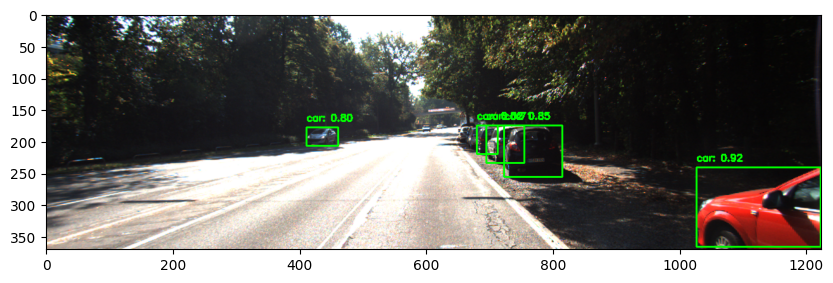

In [91]:
draw_bboxes(img)

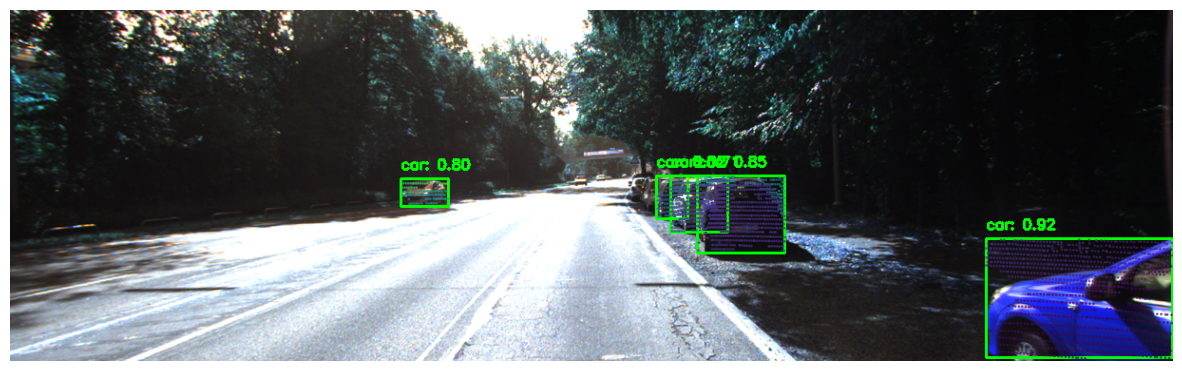

In [92]:
visualize_projection(img, points_2d, depths)

In [93]:
blank_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

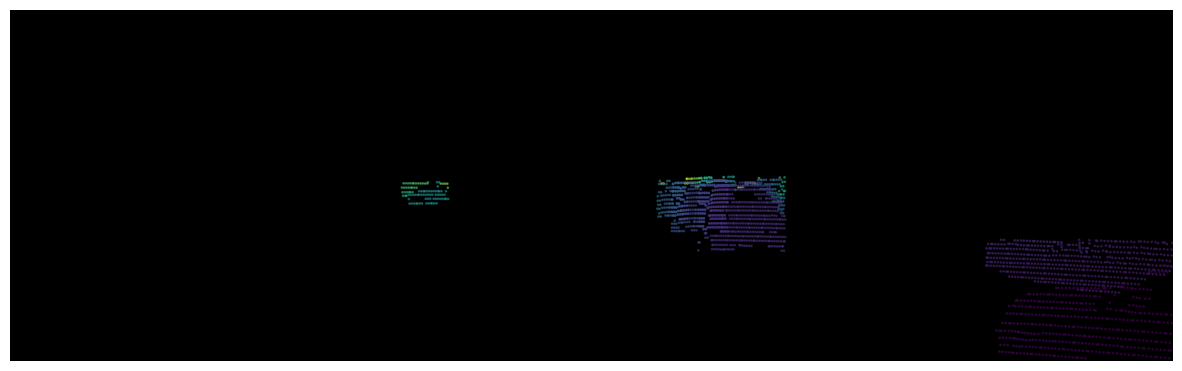

In [94]:
visualize_projection(blank_image, points_2d, depths)